# Classical neural network

In classical machine learning, a neural network is composed of nodes that are interconnected with edges. A node represent a real number that will be multiplied with the weight in the edge connecting that node to the next node, before the value is passed to the next node.

One example of a neural network is shown in the figure below.

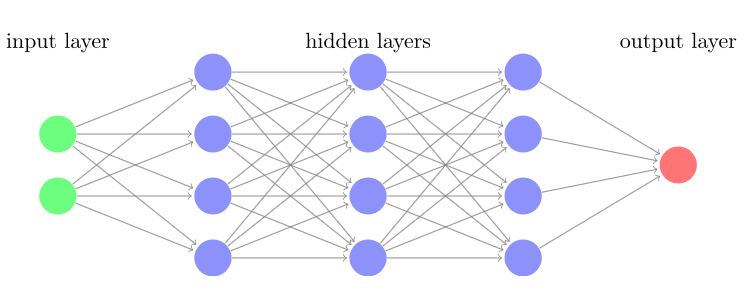

If one layer has $n$ neurons, then the next layer that has $m$ neurons will have value of:

$$
\mathcal{L}(\mathbf{x})=\varphi(W \mathbf{x}+\mathbf{b})
$$

where:

- $W \in \mathbb{R}^{m \times n}$ is a matrix,
- $b \in \mathbb{R}^{m}$ is a vector, and
- $\varphi$ is a nonlinear function (also known as the activation function), typically use ReLU or sigmoid funcion.

We will compute the output by propagating the value forward through each nodes and at the end of it, we will compare the output with the ground truth from the training set and compute a cost function. We will then tune the weights using a variation of gradient descent algorithm.

# Quantum neural network

In quantum neural network (QNN), we aim to encode the neural networks into a quantum system. We would like to harness the power of quantum information processing to improve the neural network architecture.

In short, our goal is to create a quantum circuit that performs the following mapping:

$$
|\mathbf{x}\rangle \Rightarrow|\varphi(W \mathbf{x}+\mathbf{b})\rangle
$$

Where we encode our input to the N-dimensional data in quadrature value, for example the position eigenstates.

$$
\mathbf{x} \Leftrightarrow|\mathbf{x}\rangle:=\left|x_{1}\right\rangle \otimes \ldots \otimes\left|x_{N}\right\rangle
$$

In particular, QNN that is based on CV model has advantage that it suits the continuous nature of neural networks, e.g., the nodes and edges are likely to have some value that is continuous rather than discrete.

We can find the equivalent quantum gate to achieve the desired output function.

1. Weights $W$ can be achieved using interferometers (composed of beam splitters and rotation gates) and squeezer gates.

The matrix $W$ can be decomposed into $W=O_{2} \Sigma O_{1}$ where $O_{k}$ are orthogonal matrices and $\Sigma$ is a positive diagonal matrix.

The matrix $O_{k}$ can be achieved using some interferometers and the matrix $\Sigma$ can be achieved using squeezing gates.

$$
U_{k}\left(\theta_{k}, \mathbf{0}\right)|\mathbf{x}\rangle=\left|O_{k} \mathbf{x}\right\rangle
$$

$$
\otimes_{i=1}^{N} S\left(r_{i}\right)|\mathbf{x}\rangle \propto|\Sigma \mathbf{x}\rangle
$$

2. Bias $b$ can be achieved by using displacement gate

$$
\otimes_{i=1}^{N} D\left(\alpha_{i}\right)|\mathbf{x}\rangle=|\mathbf{x}+\mathbf{b}\rangle
$$

3. Activation function $\Phi$ can be achieved using non-gaussian gates.

$$
\otimes_{i=1}^{N} \Phi\left(\lambda_{i}\right)|\mathbf{x}\rangle=|\Phi ( \mathbf{x} ) \rangle
$$

The layer is drawn in the following block diagram.

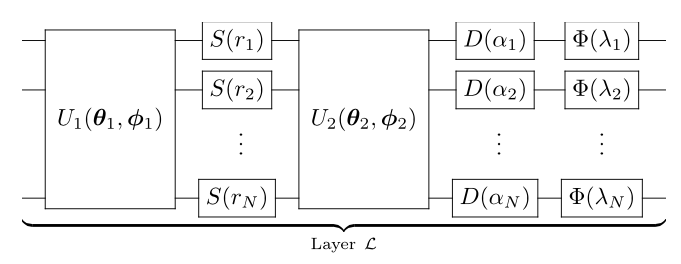

Or we in detailed what is inside when we have one and four input modes.

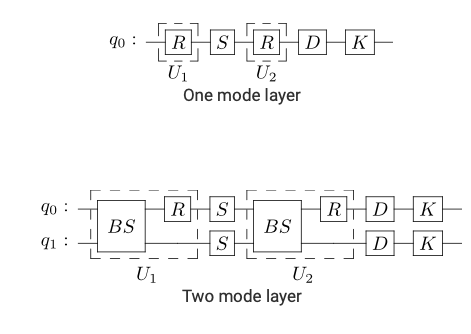

Where the interferometer is decomposed in terms of beam splitter and rotation gates and the non-gaussian gate is chosen to be the Kerr gate.

# Example

Now we would like to see an application of the QNN. We would like to create a neural network that generates single photon given the input.

First, we import all necessary modules.

In [1]:
import numpy as np
import tensorflow as tf
import strawberryfields as sf
from strawberryfields import ops

Next, we will define some functions that we will use for our neural network. The first one is the interferometer.

In [2]:
def interferometer(params, q):
    """Parameterised interferometer acting on ``N`` modes.

    Args:
        params (list[float]): list of length ``max(1, N-1) + (N-1)*N`` parameters.

            * The first ``N(N-1)/2`` parameters correspond to the beamsplitter angles
            * The second ``N(N-1)/2`` parameters correspond to the beamsplitter phases
            * The final ``N-1`` parameters correspond to local rotation on the first N-1 modes

        q (list[RegRef]): list of Strawberry Fields quantum registers the interferometer
            is to be applied to
    """
    N = len(q)
    theta = params[:N*(N-1)//2]
    phi = params[N*(N-1)//2:N*(N-1)]
    rphi = params[-N+1:]

    if N == 1:
        # the interferometer is a single rotation
        ops.Rgate(rphi[0]) | q[0]
        return

    n = 0  # keep track of free parameters

    # Apply the rectangular beamsplitter array
    # The array depth is N
    for l in range(N):
        for k, (q1, q2) in enumerate(zip(q[:-1], q[1:])):
            # skip even or odd pairs depending on layer
            if (l + k) % 2 != 1:
                ops.BSgate(theta[n], phi[n]) | (q1, q2)
                n += 1

    # apply the final local phase shifts to all modes except the last one
    for i in range(max(1, N - 1)):
        ops.Rgate(rphi[i]) | q[i]

The second function is called layer that represent the layers.

In [3]:
def layer(params, q):
    """CV quantum neural network layer acting on ``N`` modes.

    Args:
        params (list[float]): list of length ``2*(max(1, N-1) + N**2 + n)`` containing
            the number of parameters for the layer
        q (list[RegRef]): list of Strawberry Fields quantum registers the layer
            is to be applied to
    """
    N = len(q)
    M = int(N * (N - 1)) + max(1, N - 1)

    int1 = params[:M]
    s = params[M:M+N]
    int2 = params[M+N:2*M+N]
    dr = params[2*M+N:2*M+2*N]
    dp = params[2*M+2*N:2*M+3*N]
    k = params[2*M+3*N:2*M+4*N]

    # begin layer
    interferometer(int1, q)

    for i in range(N):
        ops.Sgate(s[i]) | q[i]

    interferometer(int2, q)

    for i in range(N):
        ops.Dgate(dr[i], dp[i]) | q[i]
        ops.Kgate(k[i]) | q[i]

The third function is called init_weights that will initialize the weights of our neural network.

In [4]:
def init_weights(modes, layers, active_sd=0.0001, passive_sd=0.1):
    """Initialize a 2D TensorFlow Variable containing normally-distributed
    random weights for an ``N`` mode quantum neural network with ``L`` layers.

    Args:
        modes (int): the number of modes in the quantum neural network
        layers (int): the number of layers in the quantum neural network
        active_sd (float): the standard deviation used when initializing
            the normally-distributed weights for the active parameters
            (displacement, squeezing, and Kerr magnitude)
        passive_sd (float): the standard deviation used when initializing
            the normally-distributed weights for the passive parameters
            (beamsplitter angles and all gate phases)

    Returns:
        tf.Variable[tf.float32]: A TensorFlow Variable of shape
        ``[layers, 2*(max(1, modes-1) + modes**2 + modes)]``, where the Lth
        row represents the layer parameters for the Lth layer.
    """
    # Number of interferometer parameters:
    M = int(modes * (modes - 1)) + max(1, modes - 1)

    # Create the TensorFlow variables
    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    dp_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat(
        [int1_weights, s_weights, int2_weights, dr_weights, dp_weights, k_weights], axis=1
    )

    weights = tf.Variable(weights)

    return weights

Note that we will train our QNN classically by using gradient descent algorithm. We can also train the network on the quantum hardware itself, or do a hybrid quantum-classical training like in Pennylane but in this example, we will stick with classical training.

In this example, we will have one input mode and eight layers neural network. Moreover, we will set the fock-basis cutoff dimension as six. At the end, we will see that our QNN will output the desired single photon state.

Our cost function is the fidelity function that tell us how close the output state from our QNN to the ground truth state of single photon. The fidelity function is defined as the inner product between two state:

$$
f(w)=\left\langle\psi(w) \mid \psi_{t}\right\rangle
$$

where:

$$
|\psi(w)\rangle = output state from QNN
$$


$$
|\psi_t\rangle = single photon state
$$

Now we will initialize our engine, weights and the number of parameters.

In [6]:
# initialize engine and program
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
qnn = sf.Program(modes)

# initialize QNN weights
weights = init_weights(modes, layers) # our TensorFlow weights
num_params = np.prod(weights.shape)   # total number of parameters in our model

We will use the symbolic arguments from Strawberry Fields to map the gates to TensorFLow variables when the engine is executed.

Next, we will define the cost function as well as the norm $\left\|\psi(w)-\psi_{t}\right\|$. On top of that, we will compute the trace of the output state to ensure that the state is a valid quantum state. The trace should be equal to one.

In [8]:
def cost(weights):
    # Create a dictionary mapping from the names of the Strawberry Fields
    # symbolic gate parameters to the TensorFlow weight values.
    mapping = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}

    # run the engine
    state = eng.run(qnn, args=mapping).state
    ket = state.ket()

    difference = tf.reduce_sum(tf.abs(ket - target_state))
    fidelity = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state)) ** 2
    return difference, fidelity, ket, tf.math.real(state.trace())

Now we are ready to train our QNN.

In [ ]:
# set up the optimizer
opt = tf.keras.optimizers.Adam()
cost_before, fidelity_before, _, _ = cost(weights)

# Perform the optimization
for i in range(1000):
    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        loss, fid, ket, trace = cost(weights)

    # one repetition of the optimization
    gradients = tape.gradient(loss, weights)
    opt.apply_gradients(zip([gradients], [weights]))

    # Prints progress at every rep
    if i % 1 == 0:
        print("Rep: {} Cost: {:.4f} Fidelity: {:.4f} Trace: {:.4f}".format(i, loss, fid, trace))


print("\nFidelity before optimization: ", fidelity_before.numpy())
print("Fidelity after optimization: ", fid.numpy())
print("\nTarget state: ", target_state.numpy())
print("Output state: ", np.round(ket.numpy(), decimals=3))

Rep: 0 Cost: 2.0001 Fidelity: 0.0000 Trace: 1.0000
Rep: 1 Cost: 1.9978 Fidelity: 0.0001 Trace: 1.0000
Rep: 2 Cost: 1.9897 Fidelity: 0.0002 Trace: 1.0000
Rep: 3 Cost: 1.9794 Fidelity: 0.0006 Trace: 1.0000
Rep: 4 Cost: 1.9681 Fidelity: 0.0010 Trace: 1.0000
Rep: 5 Cost: 1.9632 Fidelity: 0.0016 Trace: 1.0000
Rep: 6 Cost: 1.9563 Fidelity: 0.0023 Trace: 1.0000
Rep: 7 Cost: 1.9476 Fidelity: 0.0031 Trace: 1.0000
Rep: 8 Cost: 1.9377 Fidelity: 0.0041 Trace: 1.0000
Rep: 9 Cost: 1.9268 Fidelity: 0.0052 Trace: 1.0000
Rep: 10 Cost: 1.9196 Fidelity: 0.0064 Trace: 1.0000
Rep: 11 Cost: 1.9130 Fidelity: 0.0077 Trace: 1.0000
Rep: 12 Cost: 1.9055 Fidelity: 0.0091 Trace: 1.0000
Rep: 13 Cost: 1.8971 Fidelity: 0.0107 Trace: 1.0000
Rep: 14 Cost: 1.8880 Fidelity: 0.0124 Trace: 1.0000
Rep: 15 Cost: 1.8789 Fidelity: 0.0142 Trace: 1.0000
Rep: 16 Cost: 1.8695 Fidelity: 0.0162 Trace: 1.0000
Rep: 17 Cost: 1.8601 Fidelity: 0.0183 Trace: 1.0000
Rep: 18 Cost: 1.8505 Fidelity: 0.0205 Trace: 1.0000
Rep: 19 Cost: 1.8410 F

Rep: 157 Cost: 0.7161 Fidelity: 0.7245 Trace: 0.9988
Rep: 158 Cost: 0.7084 Fidelity: 0.7286 Trace: 0.9987
Rep: 159 Cost: 0.7013 Fidelity: 0.7327 Trace: 0.9987
Rep: 160 Cost: 0.6940 Fidelity: 0.7366 Trace: 0.9986
Rep: 161 Cost: 0.6865 Fidelity: 0.7405 Trace: 0.9985
Rep: 162 Cost: 0.6808 Fidelity: 0.7445 Trace: 0.9985
Rep: 163 Cost: 0.6737 Fidelity: 0.7483 Trace: 0.9984
Rep: 164 Cost: 0.6663 Fidelity: 0.7519 Trace: 0.9983
Rep: 165 Cost: 0.6586 Fidelity: 0.7556 Trace: 0.9982
Rep: 166 Cost: 0.6534 Fidelity: 0.7594 Trace: 0.9982
Rep: 167 Cost: 0.6468 Fidelity: 0.7630 Trace: 0.9981
Rep: 168 Cost: 0.6380 Fidelity: 0.7664 Trace: 0.9980
Rep: 169 Cost: 0.6329 Fidelity: 0.7697 Trace: 0.9979
Rep: 170 Cost: 0.6259 Fidelity: 0.7731 Trace: 0.9978
Rep: 171 Cost: 0.6188 Fidelity: 0.7767 Trace: 0.9978
Rep: 172 Cost: 0.6120 Fidelity: 0.7800 Trace: 0.9977
Rep: 173 Cost: 0.6048 Fidelity: 0.7831 Trace: 0.9976
Rep: 174 Cost: 0.5987 Fidelity: 0.7863 Trace: 0.9975
Rep: 175 Cost: 0.5909 Fidelity: 0.7896 Trace: 

Rep: 312 Cost: 0.1481 Fidelity: 0.9614 Trace: 0.9766
Rep: 313 Cost: 0.1446 Fidelity: 0.9618 Trace: 0.9764
Rep: 314 Cost: 0.1404 Fidelity: 0.9626 Trace: 0.9764
Rep: 315 Cost: 0.1366 Fidelity: 0.9633 Trace: 0.9764
Rep: 316 Cost: 0.1336 Fidelity: 0.9637 Trace: 0.9762
Rep: 317 Cost: 0.1308 Fidelity: 0.9641 Trace: 0.9761
Rep: 318 Cost: 0.1263 Fidelity: 0.9649 Trace: 0.9761
Rep: 319 Cost: 0.1222 Fidelity: 0.9654 Trace: 0.9759
Rep: 320 Cost: 0.1216 Fidelity: 0.9657 Trace: 0.9757
Rep: 321 Cost: 0.1159 Fidelity: 0.9664 Trace: 0.9756
Rep: 322 Cost: 0.1139 Fidelity: 0.9674 Trace: 0.9758
Rep: 323 Cost: 0.1109 Fidelity: 0.9680 Trace: 0.9757
Rep: 324 Cost: 0.1051 Fidelity: 0.9682 Trace: 0.9755
Rep: 325 Cost: 0.1036 Fidelity: 0.9682 Trace: 0.9752
Rep: 326 Cost: 0.1020 Fidelity: 0.9686 Trace: 0.9751
Rep: 327 Cost: 0.0949 Fidelity: 0.9694 Trace: 0.9752
Rep: 328 Cost: 0.0934 Fidelity: 0.9702 Trace: 0.9752
Rep: 329 Cost: 0.0901 Fidelity: 0.9705 Trace: 0.9751
Rep: 330 Cost: 0.0845 Fidelity: 0.9706 Trace: 

Rep: 467 Cost: 0.0184 Fidelity: 0.9740 Trace: 0.9740
Rep: 468 Cost: 0.0170 Fidelity: 0.9740 Trace: 0.9740
Rep: 469 Cost: 0.0186 Fidelity: 0.9737 Trace: 0.9737
Rep: 470 Cost: 0.0162 Fidelity: 0.9738 Trace: 0.9738
Rep: 471 Cost: 0.0196 Fidelity: 0.9740 Trace: 0.9740
Rep: 472 Cost: 0.0194 Fidelity: 0.9740 Trace: 0.9740
Rep: 473 Cost: 0.0169 Fidelity: 0.9737 Trace: 0.9737
Rep: 474 Cost: 0.0194 Fidelity: 0.9737 Trace: 0.9737
Rep: 475 Cost: 0.0194 Fidelity: 0.9739 Trace: 0.9739
Rep: 476 Cost: 0.0169 Fidelity: 0.9740 Trace: 0.9740
Rep: 477 Cost: 0.0223 Fidelity: 0.9738 Trace: 0.9739
Rep: 478 Cost: 0.0200 Fidelity: 0.9738 Trace: 0.9739
Rep: 479 Cost: 0.0183 Fidelity: 0.9740 Trace: 0.9740
Rep: 480 Cost: 0.0195 Fidelity: 0.9740 Trace: 0.9740
Rep: 481 Cost: 0.0188 Fidelity: 0.9739 Trace: 0.9739
Rep: 482 Cost: 0.0192 Fidelity: 0.9740 Trace: 0.9740
Rep: 483 Cost: 0.0168 Fidelity: 0.9742 Trace: 0.9742
Rep: 484 Cost: 0.0195 Fidelity: 0.9741 Trace: 0.9741
Rep: 485 Cost: 0.0187 Fidelity: 0.9740 Trace: 

Rep: 622 Cost: 0.0163 Fidelity: 0.9756 Trace: 0.9756
Rep: 623 Cost: 0.0153 Fidelity: 0.9757 Trace: 0.9757
Rep: 624 Cost: 0.0160 Fidelity: 0.9759 Trace: 0.9759
Rep: 625 Cost: 0.0156 Fidelity: 0.9759 Trace: 0.9759
Rep: 626 Cost: 0.0165 Fidelity: 0.9758 Trace: 0.9758
Rep: 627 Cost: 0.0138 Fidelity: 0.9758 Trace: 0.9758
Rep: 628 Cost: 0.0146 Fidelity: 0.9758 Trace: 0.9758
Rep: 629 Cost: 0.0136 Fidelity: 0.9758 Trace: 0.9758
Rep: 630 Cost: 0.0154 Fidelity: 0.9759 Trace: 0.9759
Rep: 631 Cost: 0.0137 Fidelity: 0.9759 Trace: 0.9759
Rep: 632 Cost: 0.0169 Fidelity: 0.9757 Trace: 0.9757
Rep: 633 Cost: 0.0166 Fidelity: 0.9758 Trace: 0.9758
Rep: 634 Cost: 0.0160 Fidelity: 0.9760 Trace: 0.9760
Rep: 635 Cost: 0.0150 Fidelity: 0.9759 Trace: 0.9759
Rep: 636 Cost: 0.0180 Fidelity: 0.9758 Trace: 0.9758
Rep: 637 Cost: 0.0142 Fidelity: 0.9759 Trace: 0.9759
Rep: 638 Cost: 0.0174 Fidelity: 0.9760 Trace: 0.9761
Rep: 639 Cost: 0.0167 Fidelity: 0.9760 Trace: 0.9760
Rep: 640 Cost: 0.0159 Fidelity: 0.9757 Trace: 

You can see that the fidelity is increasing as you train the QNN.